In [1]:
import cv2
import numpy as np
from cvlib.object_detection import ObjectDetection
from cvlib.tracker import EuclideanDistTracker
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
sns.set_style("white")

In [2]:
# Name for class
class_ref =['car', 'motorbike']
# Class to take set None to take all class
take_class = [0]
# Is render the video
render = True
# Video resize
width = 848
height = 477
dim = (width, height)
# Rectangle to process
cap_x, cap_y, cap_w, cap_h = 0, 0, width, height 
acceptable = 5
base_dis = 25

In [3]:
def image_resize(img, dim):
    return cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

In [4]:
def draw_with_alpha(img, draw_function, up, lp, color, width, alpha=0.5):
    overlay = np.zeros_like(img, dtype=np.uint8)
    draw_function(overlay, up, lp, color, width)
    mask = overlay.astype(bool)
    img[mask] = cv2.addWeighted(img, alpha, overlay, 1 - alpha, 0)[mask]


In [5]:
detector = ObjectDetection()
tracker = EuclideanDistTracker()

Dectector model is loading...
Dectector model is ready now


In [31]:
def process(frame,dis_scalar = 1, conf = 0.3, iou = 0.5, show_cap = False):
    line = int(cap_h*0.70)
    frame = image_resize(frame, dim)
    roi = frame[cap_y:cap_y + cap_h, cap_x:cap_x + cap_w]
    results, classes = detector.predict(roi, specific_class=take_class)
    if show_cap:
        #cv2.rectangle(frame, (cap_x, cap_y), (cap_x + cap_w, cap_y + cap_h), (255, 255, 0), 2)
        cv2.line(roi, (0, line), (cap_w, line), (107, 214, 205), 2)
        draw_with_alpha(frame, cv2.rectangle, (cap_x, cap_y), (cap_x + cap_w, cap_y + cap_h), (255, 255, 0), 2)
        # cv2.line(roi, (0, line+acceptable), (cap_w, line+acceptable), (214, 214, 214), 2)
        # cv2.line(roi, (0, line-acceptable), (cap_w, line-acceptable), (214, 214, 214), 2)
        draw_with_alpha(roi, cv2.line, (0, line+acceptable), (cap_w, line+acceptable), (214, 214, 214), 2)
        draw_with_alpha(roi, cv2.line, (0, line-acceptable-10), (cap_w, line-acceptable-10), (214, 214, 214), 2, 0.8)
    
    if len(results) > 0:
        presults = tracker.update( results, liney = line, acceptable = acceptable, delta = base_dis*dis_scalar)
        for i, package in enumerate(presults):
            ux, uy, lx, ly, id, direction = package 
            cv2.rectangle(roi, (ux, uy), (lx, ly), (0, 220, 0), 2)
            cv2.putText(roi, f"id: {str(id)}|{'in' if direction==1 else 'out'} class: {class_ref[classes[i]]}", (ux, uy - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.putText(frame, f"Vehicle Count: {str(tracker.count)}", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.putText(frame, f"Active vehicle: {len(results)}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    return frame

In [22]:
def Plot2D(frame, confs = [], ious = []):
    plt.figure(figsize=(20,12))
    for i, conf in enumerate(confs):
        for j, iou in enumerate(ious):
            plt.subplot(len(confs), len(ious), i*len(ious)+j+1)
            results, classes, plot = detector.predict(frame, specific_class=take_class, conf = conf, iou = iou, plot = True)
            plt.title(f"Conf: {conf} | IOU: {iou}")
            plot= cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
            plt.imshow(plot)
    plt.show()

In [14]:
!curl https://blog.way.com/wp-content/uploads/2022/03/los-angeles-g848620e6d_1280.jpg -o ./TestImage/los-angeles-g848620e6d_1280.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  260k  100  260k    0     0   557k      0 --:--:-- --:--:-- --:--:--  558k


In [15]:
!curl https://environmentaldefence.ca/wp-content/uploads/2020/09/Aug-7-39.jpg -o ./TestImage/Aug-7-39.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 13  711k   13 97924    0     0  61684      0  0:00:11  0:00:01  0:00:10 61703
 76  711k   76  543k    0     0   214k      0  0:00:03  0:00:02  0:00:01  214k
100  711k  100  711k    0     0   269k      0  0:00:02  0:00:02 --:--:--  269k


In [16]:
image1 = cv2.imread("./TestImage/los-angeles-g848620e6d_1280.jpg")
image2 = cv2.imread("./TestImage/Aug-7-39.jpg")

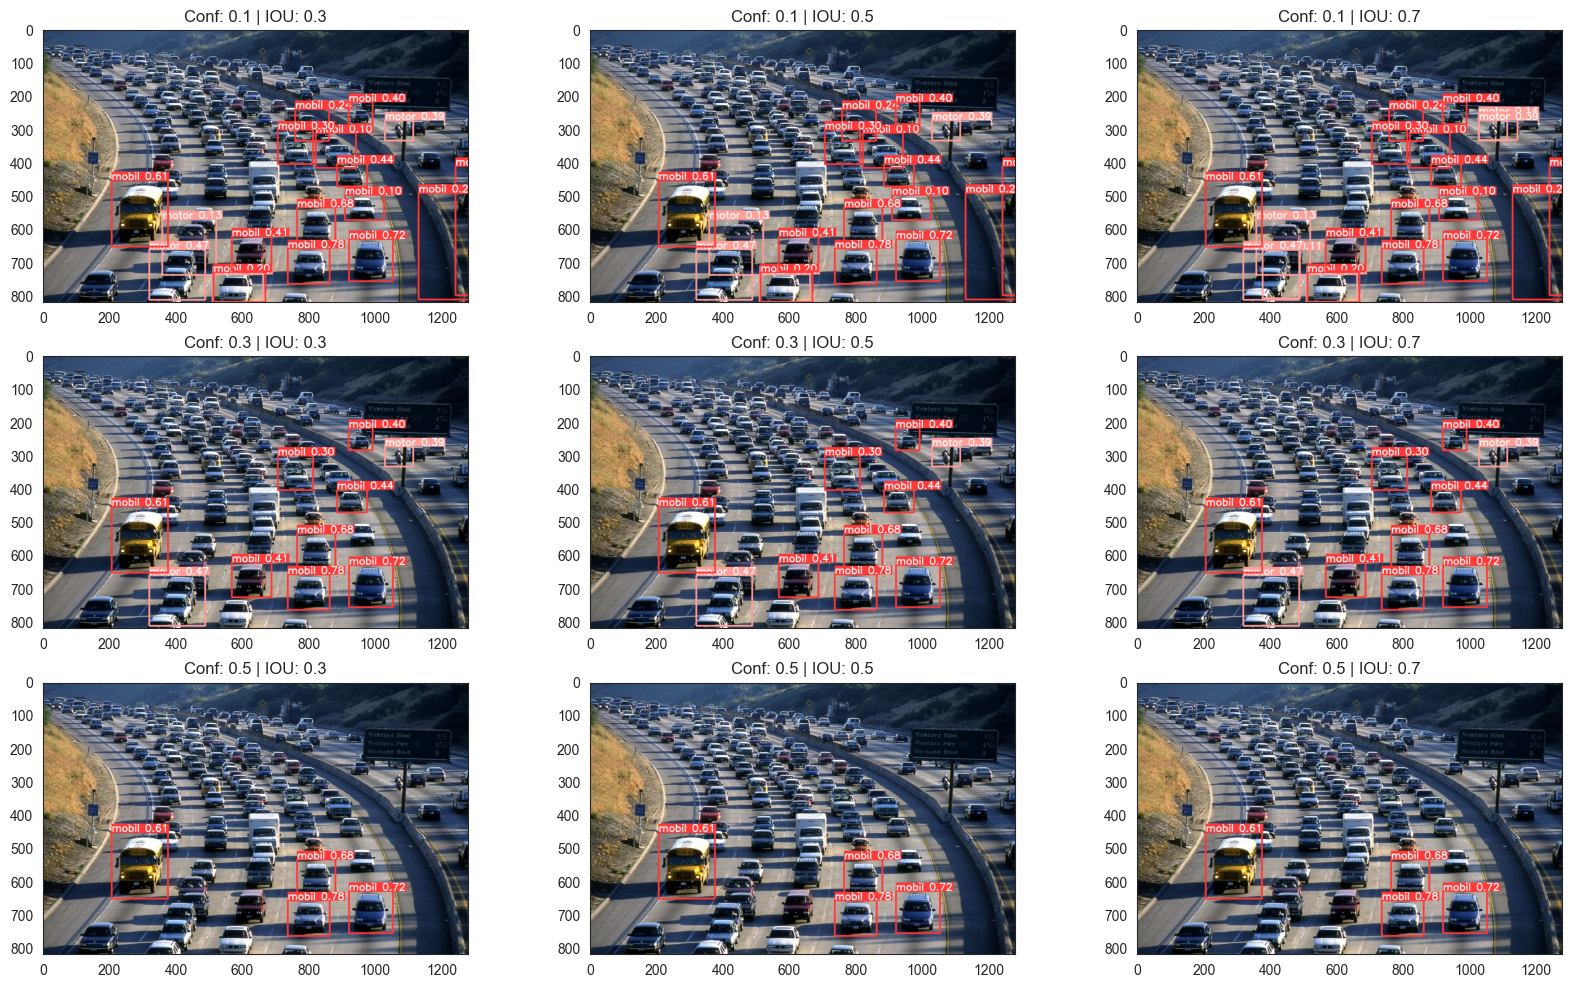

In [23]:
confs = [0.1, 0.3, 0.5]
ious = [0.3, 0.5, 0.7]
Plot2D(image1, confs, ious)

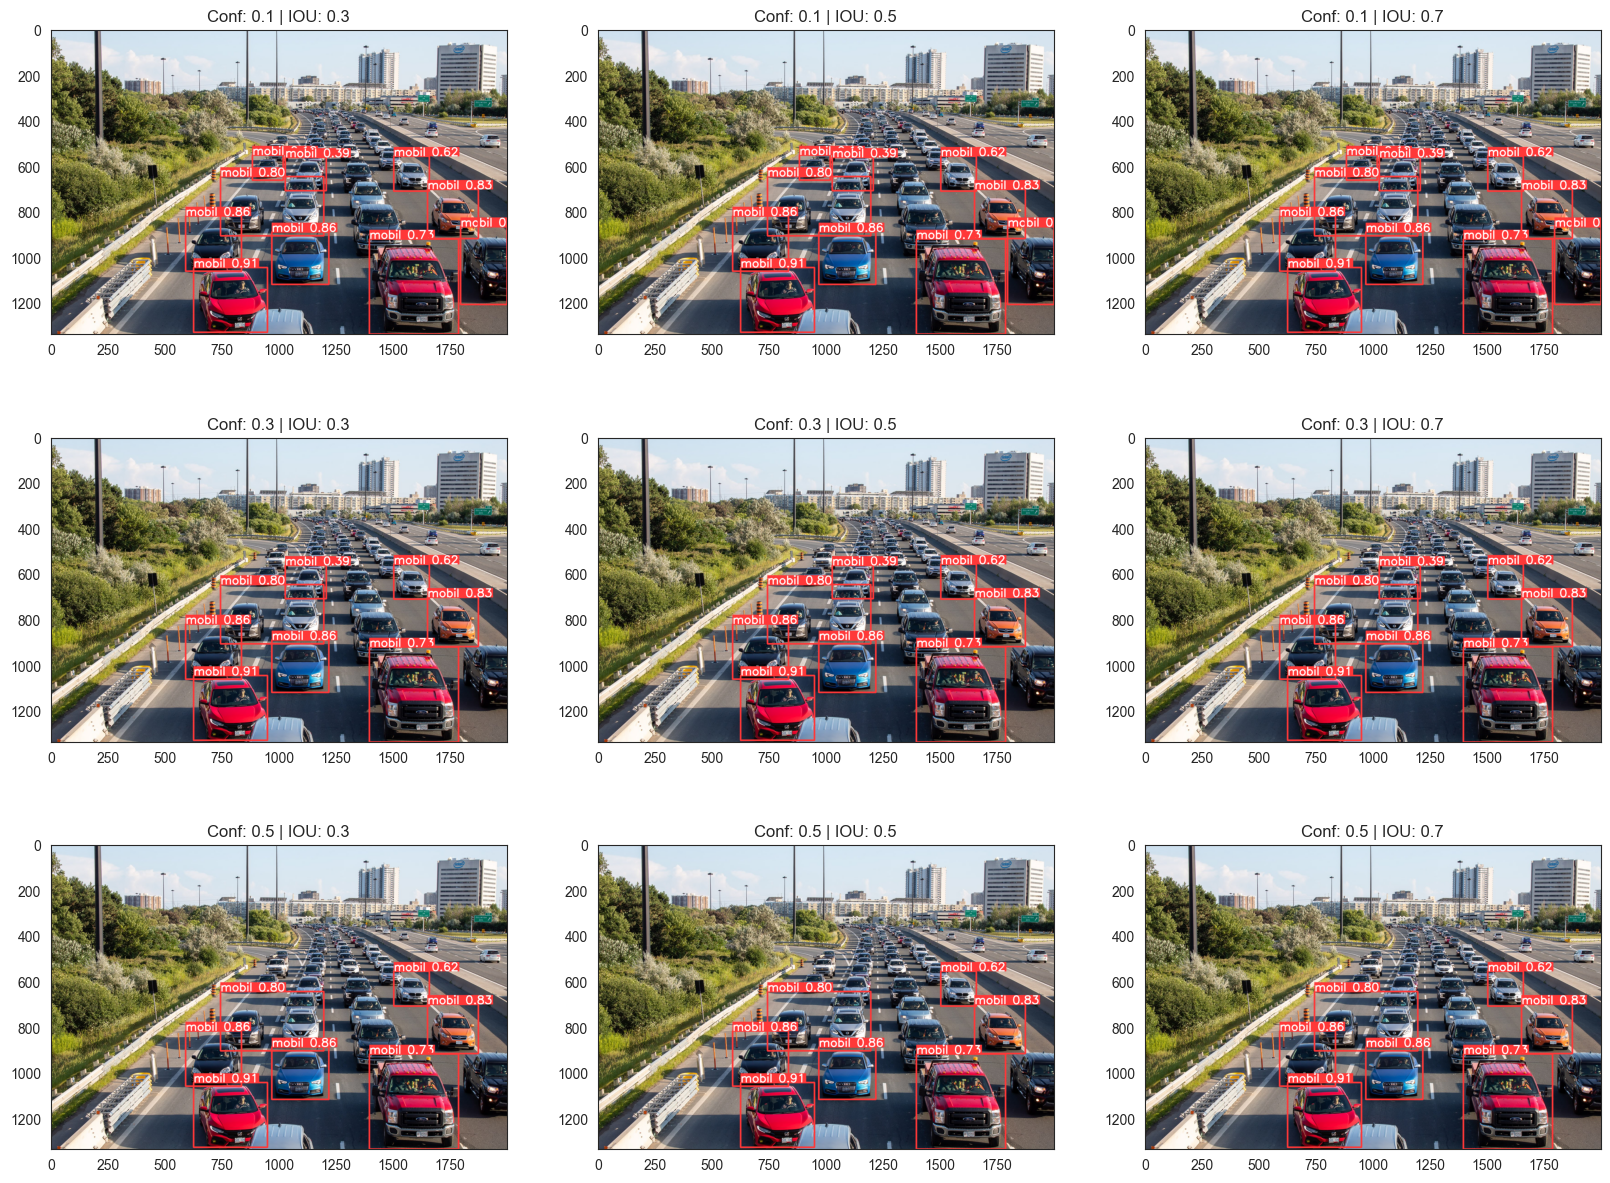

In [21]:
Plot2D(image2, confs, ious)

In [25]:
def plot_list_Frame(frame_list1, frame_list2 = None, title1= "car_cascade", title2="yolo"):
    sns.set_style("white")
    plt.figure(figsize=(20, 7 if frame_list2 != None else 5))
    w_plot = min(len(frame_list1),len(frame_list2) if frame_list2 != None else len(frame_list1))
    map(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB), frame_list1)
    if frame_list2 != None:
        map(lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB), frame_list2)
    n_row = 2 if frame_list2 != None else 1
    for i in range(w_plot):
        plt.subplot(n_row, w_plot, i+1)
        plt.imshow(frame_list1[i])
        plt.title(title1)
        if frame_list2 != None:
            plt.subplot(n_row, w_plot, i+1+w_plot)
            plt.imshow(frame_list2[i])
            plt.title(title2)
    plt.show()
    sns.set_style("whitegrid")

In [24]:
video_name = 'camera2'
video_capture = cv2.VideoCapture(f"./Videos/{video_name}.mp4")

In [26]:
import time
start_frame = 150
max_of_frame = 50


In [32]:
n_of_frame = 0
video_capture.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
tic = time.time()
yolo_time = []
yolo_frame_take = []
while True:
    ret, frame = video_capture.read()
    if ret:

        frame = image_resize(frame, dim)
        frame = process(frame, dis_scalar = 1, conf = 0.3, iou = 0.5, show_cap = True)
        yolo_frame_take.append(frame)
        tic = time.time()
        n_of_frame += 1
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, start_frame + n_of_frame*1)
        # if render:
        #     video_results.write(frame)
        # cv2.imshow("frame", frame)
    else:
        break;
    if n_of_frame == max_of_frame:
        break;

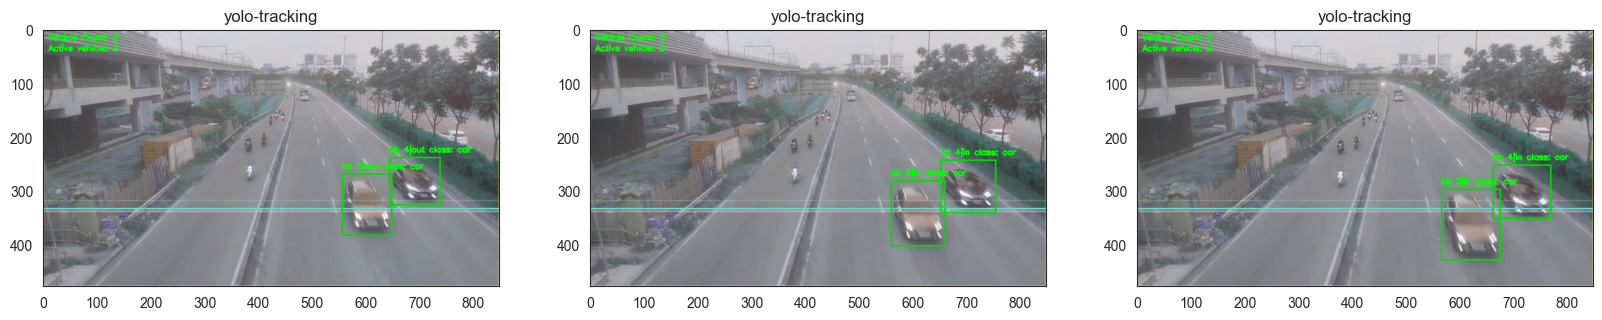

In [33]:
plot_list_Frame(yolo_frame_take[:6:2], title1="yolo-tracking")

In [51]:
video1_conf = np.array([
    [19, 0],
    [0, 0]
])
video1_conf = pd.DataFrame(video1_conf, columns = ["predict-true", "predict_false"], index = ["true", "false"])

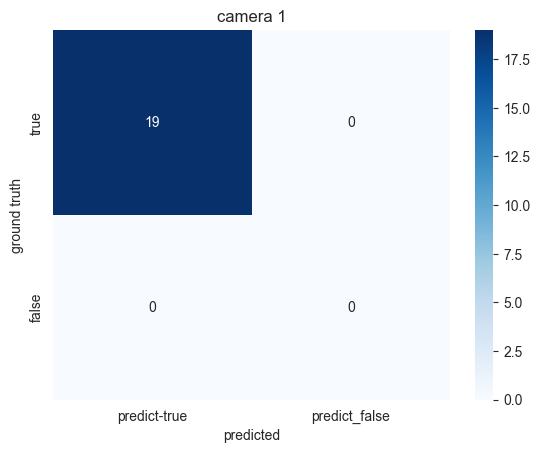

In [52]:
sns.heatmap(video1_conf, annot=True, fmt="d", cmap="Blues")
plt.xlabel("predicted")
plt.ylabel("ground truth")
plt.title("camera 1")
plt.show()

In [55]:
video2_conf = np.array([
    [20, 1],
    [0, 0]
])
video2_conf = pd.DataFrame(video2_conf, columns = ["predict-true", "predict_false"], index = ["true", "false"])

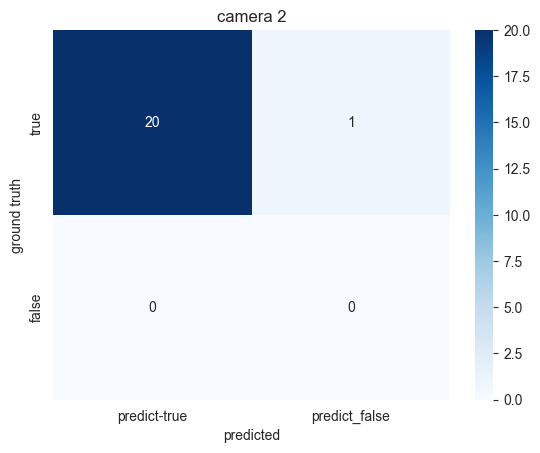

In [56]:
sns.heatmap(video2_conf, annot=True, fmt="d", cmap="Blues")
plt.xlabel("predicted")
plt.ylabel("ground truth")
plt.title("camera 2")
plt.show()

In [66]:

def classification_report2(confusion_matrix):
    num_classes = len(confusion_matrix)
    report = "              precision    recall  f1-score   support\n\n"

    for class_idx in range(num_classes):
        # Calculate metrics
        true_positives = confusion_matrix[class_idx, class_idx]
        false_positives = np.sum(confusion_matrix[:, class_idx]) - true_positives
        false_negatives = np.sum(confusion_matrix[class_idx, :]) - true_positives

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)
        f1_score = 2 * (precision * recall) / (precision + recall)
        support = np.sum(confusion_matrix[class_idx, :])

        # Append class metrics to the report
        report += f"Class {class_idx:2d}:     {precision:.4f}     {recall:.4f}     {f1_score:.4f}     {support:4d}\n"

    # Calculate averages for micro/macro metrics
    total_true_positives = np.trace(confusion_matrix)
    total_false_positives = np.sum(confusion_matrix, axis=0) - total_true_positives
    total_false_negatives = np.sum(confusion_matrix, axis=1) - total_true_positives

    micro_precision = total_true_positives / np.sum(total_true_positives + total_false_positives)
    micro_recall = total_true_positives / np.sum(total_true_positives + total_false_negatives)
    micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1_score = np.mean(f1_score)

    # Append micro/macro metrics to the report
    report += f"\nMicro Avg:     {micro_precision:.4f}     {micro_recall:.4f}     {micro_f1_score:.4f}     {np.sum(confusion_matrix):4d}\n"
    report += f"Macro Avg:     {macro_precision:.4f}     {macro_recall:.4f}     {macro_f1_score:.4f}     {np.sum(confusion_matrix):4d}\n"

    return report



In [61]:
video1_list_true = np.ones(20)
video1_list_pred = np.ones(20)
video2_list_pred = np.ones(21)
video2_list_true = np.ones(21)
video2_list_pred[12] = 0


In [62]:
from sklearn.metrics import classification_report, confusion_matrix

In [63]:
print(classification_report(video1_list_true, video1_list_pred))
print(classification_report(video2_list_true, video2_list_pred))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.95      0.98        21

    accuracy                           0.95        21
   macro avg       0.50      0.48      0.49        21
weighted avg       1.00      0.95      0.98        21



C:\Users\drawt\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\drawt\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\drawt\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
